# Spatial variability in brightness temperature 

In [1]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import kray
# OS interaction
import sys, pickle, os
# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec
from moviepy.editor import *

# --------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'
# Directory for printing figures
dirPrint = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/Graphics/IR_SnoqualmieFlights'
# Met data directory
dirData = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ/IR_SnoqualmieFlights'
dirDataGrobs = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ/'

# --------------------------------------------------------------------------------------------
# Global formatting
sns.set_context('talk')
sns.set_style('whitegrid')
# must insert this statement to render the plots within the notebook
%matplotlib inline

# Functions

In [2]:
import utm


def readIMU(fname):
    # Column 1 is time
    # Columns 12 and 13 are lat and lon
    # Columns 2-9 are actually column 2 in the readme and original MATLAB code - they are demarked using a semi-colon

    try:
        # Pandas based reading of the gps file
        temp = pd.read_csv(fname, skiprows=1, header=None, index_col=[0])

        # Drop rows with "#BESTPOSA"
        temp = temp[temp[1] != '#BESTPOSA']
        d = {'lat': temp[12],
             'lon': temp[13],
             'pitch': temp[19],
             'roll': temp[18],
             'azmth': temp[20],
             'elev': temp[14],
             'velocity': temp[17]}
        gpsFile = pd.DataFrame(d)
        gpsFile.index.rename('time', inplace=True)

        # Convert to numpy64 datetime objects (epochTime is in seconds since 1970)
        gpsFile.index = [datetime.fromtimestamp(d) for d in gpsFile.index.values]
        gpsFile.index.rename('time', inplace=True)

        # Convert to UTM coordinates - returned from function (lat, lon, zone, _)
        [gpsFile['easting'], gpsFile['northing'], gpsFile['zone']] = zip(
            *(utm.from_latlon(lat, lon)[0:3] for (lat, lon) in zip(gpsFile.lat, gpsFile.lon)))
    except ValueError:
        # GPS file likely only contains the "#BESTPOSA" without a corresponding "#INSPVAA" row.
        # Return just the GPS locations instead of the IMU+GPS (I think). Return an empty Dataset.
        print("No location data found in: " + fname)
        return xr.Dataset()

    return(xr.Dataset.from_dataframe(gpsFile))

In [19]:
def undistortUV(Ud, Vd, ip):
    '''
    [U V] = undistortUV(Ud,Vd,ip)
    ip - [lx ly uWidth vWidth u0 v0 d1 d2]
    '''
    # separate parameters
    lu = ip[0]
    lv = ip[1]
    Uo = ip[4]
    Vo = ip[5]
    d1 = ip[6]
    d2 = ip[7]
    if len(ip) > 8:
        d3 = ip[8]

    # calculate radius
    r = np.sqrt((lu * Ud - Uo)**2 + (lv * Vd - Vo)**2)

    # calculate scaling factor
    if len(ip) > 8:
        s = 1 + d1 * r**2 + d3 * r + d2
    else:
        s = 1 + d1 * r**2 + d2

    # undistort UV
    U = ((lu * Ud - Uo) * s + Uo) / lu
    V = ((lv * Vd - Vo) * s + Vo) / lv 
    
    return(U, V)

In [22]:
def infoPRY2M(angles, camera, ip, 
              oPitch=None, oRoll=None, oYaw=None):
    '''
    infoPRY2M -- convert ptich, roll yaw angles and camera/IP data to M vector
    
    m = info2M( angles, camera, ip ) converts the angle data into
    a Walton M vector based on camera location and IP data.

    Angles is a 4x1 or 1x4 array of angles in the order [pitch
    yaw hfov roll], in radians

    Camera is a 3 element vector of camera location values in the order
    [x y z].

    IP is a 6 element vector in order of [lx ly uWidth vWidth u0 v0].
    Or IP is the usual ip structure format.
    '''
    
    # set parameters
    pitch, yaw, fov, roll  = angles
    cx, cy, cz = camera
    lu = ip[0]
    lv = ip[1]
    width = ip[2]
    u0 = ip[4]
    v0 = ip[5]

    # use camera space
    f = width/ 2 / np.tan(fov / 2)

    # INS rotation matrix
    a = np.array([np.cos(yaw), np.sin(yaw), 0,
                  -np.sin(yaw), np.cos(yaw), 0,
                  0, 0, 1]).reshape(3, 3)
    b = np.array([np.cos(roll), 0, -np.sin(roll),
                  0, 1, 0,
                  np.sin(roll), 0, np.cos(roll)]).reshape(3, 3)
    c = np.array([1, 0, 0,
                  0, np.cos(pitch), np.sin(pitch),
                  0, -np.sin(pitch), np.cos(pitch)]).reshape(3, 3)

    # offset rotation to the cameras
    if oPitch is not None or oRoll is not None or oYaw is not None:
        a2 = np.array([np.cos(oYaw), np.sin(oYaw), 0,
              -np.sin(oYaw), np.cos(oYaw), 0,
              0, 0, 1]).reshape(3, 3)
        b2 = np.array([np.cos(oRoll), 0, -np.sin(oRoll),
                       0, 1, 0,
                       np.sin(oRoll), 0, np.cos(oRoll)]).reshape(3, 3)
        c2 = np.array([1, 0, 0,
                       0, np.cos(oPitch), np.sin(oPitch),
                       0, -np.sin(oPitch), np.cos(oPitch)]).reshape(3, 3)
        Rg = np.dot(np.dot(a2, b2), c2)
        # INS to local (ENU) rotation, with offset to camera rotaion
        R = np.dot(np.dot(np.dot(a, b), c), Rg).T
    else:
        # INS to local (ENU) rotation
        R = np.dot(np.dot(b, c), a)
    L = -(cx * R[2, 0] + cy * R[2, 1] + cz * R[2, 2])

    # m vector
    m = np.zeros(11)
    m[0] = lu * (u0 * R[2, 0] + f * R[0, 0]) / L
    m[1] = lu * (u0 * R[2, 1] + f * R[0, 1]) / L
    m[2] = lu * (u0 * R[2, 2] + f * R[0, 2]) / L

    m[3] = -(m[0] * cx + m[1] * cy + m[2] * cz)

    m[4] = R[2, 0] / L
    m[5] = R[2, 1] / L
    m[6] = R[2, 2] / L

    m[7] = lv * (v0 * R[2, 0] + f * R[1, 0]) / L
    m[8] = lv * (v0 * R[2, 1] + f * R[1, 1]) / L
    m[9] = lv * (v0 * R[2, 2] + f * R[1, 2]) / L

    m[10] = -(m[7] * cx + m[8] * cy + m[9] * cz)

    return m

In [23]:
def findXYZ(m, U, V, val, flag):
    #
    #  XYZ = findXYZ(m, UV, val, flag)
    #
    #  Routine to find new [x y z] location based on the image geometry, m,
    #  and image coordinates, UV.  The Direct Linear Transformation (DLT)
    #  equations, which transform the XYZ world coordinates into UV image
    #  coordinates:
    #
    #       U = (Ax + By + Cz + D)/(Ex + Fy + Gz + 1);
    #       V = (Hx + Jy + Kz + L)/(Ex + Fy + Gz + 1);
    #
    #  can be rearranged to solve for x, y, or z in terms of the image coordinates.
    #  Because the system is underdetermined, one of the coordinates must be
    #  specified.  The variable, flag, indicates which of the three coordinates
    #  is known: flag=1 for x, flag=2 for y, and flag=3 for z.  The value of the
    #  known coordinate is entered into the variable val, which can be a scalar or
    #  an array.
    #
    #  Inputs:
    #   m       - geometry vector (Walton m-vector = DLT coefficients)
    #   UV      - Nx2 matrix of [U V] coordinates
    #   val     - the specific value for the known x, y, or z coordinate
    #             If val is a scalar, it is used for all UV pairs.
    #             If val is an array, it must be as long as UV.
    #   flag    - flag indicating which of the x, y, or z coordinates is known,
    #             e.g., flag = 3 implies that z is known.
    #
    #  Output:
    #   XYZ     - Nx3 matrix of [x y z] values
    #
    # Copyright by Oregon State University, 2002
    # Developed through collaborative effort of the Argus Users Group
    # For official use by the Argus Users Group or other licensed activities.
    # Holman & Paden 04/28/04

    # Build val array if not already there.
    Nu = U.size
    Nv = V.size
    if not Nv == Nu:
        raise ValueError('U and V are not the same length')
    else:
        N = Nu
    if val.size == 1:
        val = np.ones_like(U) * val
    if not val.size == N:
        raise ValueError('val variable not same length as UV list')

    # Change from Walton m-vector notation to DLT notation so don't have to
    # use subscripts
    A, B, C, D, E, F, G, H, J, K, L = m

    # Assign variable names to coefficients derived in solving for x,y, or z
    M = E * U - A
    N = F * U - B
    O = G * U - C
    P = D - U
    Q = E * V - H
    R = F * V - J
    S = G * V - K
    T = L - V

    # Solve for unknown coordinates for given known coordinate

    if flag == 0:
        X = val
        Y = ((O * Q - S * M) * X + (S * P - O * T)) / (S * N - O * R)
        Z = ((N * Q - R * M) * X + (R * P - N * T)) / (R * O - N * S)

    elif flag == 1:
        Y = val
        X = ((O * R - S * N) * Y + (S * P - O * T)) / (S * M - O * Q)
        Z = ((M * R - Q * N) * Y + (Q * P - M * T)) / (Q * O - M * S)
    elif flag == 2:
        Z = val
        X = ((N * S - R * O) * Z + (R * P - N * T)) / (R * M - N * Q)
        Y = ((M * S - Q * O) * Z + (Q * P - M * T)) / (Q * N - M * R)
    else:
        raise ValueError('Invalid flag value (must be int of 0, 1, 2)')

    return(X, Y, Z)

# Gather data

In [17]:
# --------------------------------------------------------------------------------------------
# Dictionary of all flights

# File names of the IR camera data
# VISIBLE IMAGES
# *-IR_02_STACK.txt = time file (no reference temperature)
# *-IR_02_STACK.dat = binary data file (EO)
# These data are mosaiced grbg colors. Chris uses `demosaic` in his example script.
# I need to find a similar function in python.
# paramsE = [0, 0, 8, 1280, 960] parameter for reading in the EO images

# IR Observations
# *-IR_1_STACK.txt = time file (w/ reference temperature)
# *-IR_0_STACK.txt = time file (w/ reference temperature)

# Location file
# *-INS.DAT = binary file with GPS/IMU data

fl1 = {'LOCATION': '1368565948_2013MAY14_2112CUT_PLANE-INS.DAT',
       'IR1': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.txt'}

fl2 = {'LOCATION': '1368565959_2013MAY14_2112CUT_PLANE-INS.DAT',
       'IR1': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.txt',
       'VISIBLE': '1368566727_2013MAY14_2125CUT_PLANE_DRS-IR_02_STACK.dat',
       'VISIBLE_TIME': '1368566727_2013MAY14_2125CUT_PLANE_DRS-IR_02_STACK.txt'}

fl3 = {'LOCATION': '1368567317_2013MAY14_2135CUT_PLANE-INS.DAT',
       'IR1': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.txt'}

fl4 = {'LOCATION': '1368567328_2013MAY14_2135CUT_PLANE-INS.DAT',
       'IR1': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.txt'}

fl5 = {'LOCATION': '1368567353_2013MAY14_2135CUT_PLANE-INS.DAT',
       'IR1': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.txt'}
       
fl6 = {'LOCATION': '1368567391_2013MAY14_2136CUT_PLANE-INS.DAT',
       'IR1': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_1_STACK.txt',
       'VISIBLE': '1368567853_2013MAY14_2144CUT_PLANE_DRS-IR_02_STACK.dat',
       'VISIBLE_TIME': '1368567853_2013MAY14_2144CUT_PLANE_DRS-IR_02_STACK.txt'}

fl7 = {'LOCATION': '1368574071_2013MAY14_2327CUT_PLANE-INS.DAT',
       'IR1': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_1_STACK.txt'}
            
fl8 = {'LOCATION': '1368574082_2013MAY14_2328CUT_PLANE-INS.DAT',
       'IR1': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.txt'}
       
fl9 = {'LOCATION': '1368574106_2013MAY14_2328CUT_PLANE-INS.DAT',
       'IR1': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.txt',
       'VISIBLE': '1368574151_2013MAY14_2329CUT_PLANE_DRS-IR_02_STACK.dat',
       'VISIBLE_TIME': '1368574151_2013MAY14_2329CUT_PLANE_DRS-IR_02_STACK.txt'}

fl10 = {'LOCATION': '1368575242_2013MAY14_2347CUT_PLANE-INS.DAT',
        'IR1': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368575246_2013MAY14_2347CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368575246_2013MAY14_2347CUT_PLANE_DRS-IR_02_STACK.txt'}

fl11 = {'LOCATION': '1368575946_2013MAY14_2359CUT_PLANE-INS.DAT',
        'IR1': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368575950_2013MAY14_2359CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368575950_2013MAY14_2359CUT_PLANE_DRS-IR_02_STACK.txt'}
            
fl12 = {'LOCATION': '1368578462_2013MAY15_0041CUT_PLANE-INS.DAT',
        'IR1': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368578466_2013MAY15_0041CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368578466_2013MAY15_0041CUT_PLANE_DRS-IR_02_STACK.txt'}

fl13 = {'LOCATION': '1368579145_2013MAY15_0052CUT_PLANE-INS.DAT',
        'IR1': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368579147_2013MAY15_0052CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368579147_2013MAY15_0052CUT_PLANE_DRS-IR_02_STACK.txt'}

irCameraDictionary = ['LOCATION', 'IR1', 'IR2', 'VISIBLE']

# Collect all file name dictionaries into a single array for easy iteration
irFiles  = [fl1, fl2, fl3, fl4, fl5, fl6, fl7, fl8, fl9, fl10, fl11, fl12, fl13]

# Drop flights that don't have any data
irFiles  = [fl10, fl11, fl12, fl13]

# --------------------------------------------------------------------------------------------
# Location xarray Dataset
os.chdir(dirData)

# --------------------------------------------------------------------------------------------
# Variables to pass to the read function:
paramsIR = np.array([1904, 1904, 16, 640, 480])
paramsVis = np.array([0, 0, 8, 1280, 960])
cameraLocDataset = xr.Dataset()

for irf in irFiles:
    # --------------------------------------------------------------------------------------------
    # Read GPS/IMU
    cameraLoc = readIMU(irf['LOCATION'])
    
    # Initialize dataset
    if not cameraLocDataset:
        cameraLocDataset = cameraLoc
    # Append to existing dataset
    elif cameraLocDataset:
        cameraLocDataset = xr.concat([cameraLocDataset, cameraLoc], dim='time')
        
# --------------------------------------------------------------------------------------------
# Clean up the obviously bad values.

# Remove repeated time steps (this breaks most xarray functions)
uniqueTimes, uniqueInd = np.unique(cameraLocDataset.time.values, return_index=True)
cameraLocDataset = cameraLocDataset.isel(time=uniqueInd)

# Remove obviously bad lat/lon data
badValueIndex = np.nonzero((cameraLocDataset.lat.values == 0) | (cameraLocDataset.lon.values == 0))
for dv in cameraLocDataset.data_vars:
    try:
        cameraLocDataset[dv].values[badValueIndex] = np.nan
    except ValueError:
        continue
        
# --------------------------------------------------------------------------------------------
# IR Images (sub-sampled to 1 out of every 10)
cameraDataset = xr.open_mfdataset('SNQ.IRFlight_1.*', chunks={'time': 100})

# Align location and image data
cameraLocDataset = cameraLocDataset.reindex_like(cameraDataset)
cameraDataset = xr.merge([cameraDataset, cLD], join='inner')
print(cameraDataset)

<xarray.Dataset>
Dimensions:    (time: 702, x: 480, y: 640)
Coordinates:
  * x          (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * y          (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time       (time) datetime64[ns] 2013-05-14T16:47:21.593000 ...
Data variables:
    images     (x, y, time) float64 7.255 7.079 7.159 7.159 7.415 7.287 ...
    flightNum  (time) object '2347' '2347' '2347' '2347' '2347' '2347' ...
    easting    (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    elev       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    lat        (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    zone       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    velocity   (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    azmth      (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    northing   (time) float64 nan nan nan nan nan nan nan nan nan 

## Undistortion Routine

In [29]:
# --------------------------------------------------------------------------------------------
# Undistortion coefficients

# Cameras point straight down relative to IMU orientation. Do an approximate image rectification,
# assuming a flat terrain at a fixed elevation. This will be wrong almost everywhere, but the
# basic scripts and funcitons are represented below. -- Chris comment

# Directly assign distortion coefficients instead of going to matlab
D0 = np.array([[  8.29156932e-07], [1.31482324e-02], [-2.73245123e-04]])
D1 = np.array([[  2.62118311e-07], [1.32719803e-02], [-1.23437066e-04]])

# Inherent camera parameters
ip0 = [1, -1, 640, 480, 320, -240]
ip0.extend(D0.flatten())
ip1 = [1, -1, 640, 480, 320, -240]
ip1.extend(D1.flatten())

# Mesh of distortion vectors
[Ud, Vd] = np.meshgrid(np.arange(0, ip0[2]), np.arange(0, ip0[3]))
# correct for barrel orpincusion distortion
[uU1, uV1] = undistortUV(Ud, Vd, ip1) 
[uU0, uV0] = undistortUV(Ud, Vd, ip0)
offsetAngsC0 = np.array([0, 0, 0]) * np.pi / 180

# offset to make C1 match C0
offsetAngsC1 = np.array([-.1, .1, .5]) * np.pi / 180
# need to adjust these for the focus, approximate with last used values -- Chris comment
fovC0 = 39
fovC1 = 25.5

# --------------------------------------------------------------------------------------------
# Undistortion dataset

# Undistort all images
timeSize = cameraDataset.time.size
xSize = cameraDataset.x.size
ySize = cameraDataset.y.size

chunkUndistort = xr.Dataset({'easting': (['x', 'y', 'time'], np.zeros((xSize, ySize, timeSize))),
                             'northing': (['x', 'y', 'time'], np.zeros((xSize, ySize, timeSize)))},
                            coords={'time': cameraDataset.time})
# chunkUndistort = chunkUndistort.chunk({'time': 100})

# --------------------------------------------------------------------------------------------
# Correct each image
for n, t in enumerate(cameraDataset.time):
    print('\r' + "Image " + str(n + 1) + ' of ' + str(cameraDataset.time.size), end="")
    # Dataset for this timestep
    ds = cameraLocDataset.isel(time=n)
    m0 = infoPRY2M(np.array([-ds['pitch'].values,
                             ds['azmth'].values,
                             fovC0,
                             -ds['roll'].values]) * np.pi / 180,
                    np.array([ds['easting'].values,
                              ds['northing'].values,
                              ds['elev'].values]),
                   ip0, 0, 0, 0)
    # Projection coordinates -- careful changing things here. The indexing methods of xarray will
    # silently fail when trying to assign.
    chunkUndistort['easting'][dict(time=n)], chunkUndistort['northing'][dict(time=n)], _ \
        = findXYZ(m0, uU0, uV0, np.array(1000), np.array(2)) # fixing land elevation to 1000m

Image 702 of 702

# Plot Images

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for n in np.arange(300, cameraLocDataset.time.size-175):
    m0 = infoPRY2M(np.array([-cameraLocDataset['pitch'].isel(time=n).values,
                             cameraLocDataset['azmth'].isel(time=n).values,
                             fovC0,
                             -cameraLocDataset['roll'].isel(time=n).values]) * np.pi / 180,
                    np.array([cameraLocDataset['easting'].isel(time=n).values,
                              cameraLocDataset['northing'].isel(time=n).values,
                              cameraLocDataset['elev'].isel(time=n).values]),
                   ip0, 0, 0, 0)
    # make projection locations
    X0, Y0, Z0 = findXYZ(m0, uU0, uV0, np.array(1000), np.array(2)) # fixing land elevation to 1000m
    
    # Plot IR images
    im = ax.pcolormesh(X0/1000, Y0/1000,
                  ((cameraDataset.isel(time=n) - imMean)/250).images.values + refTemp,
                  cmap=cm.gnuplot2, vmin=0, vmax=20)
    
e, n, z, _ = utm.from_latlon(47.424883, -121.413893)
ax.plot(e/1000, n/1000, 'ro', markersize=20)
fig.colorbar(im)

In [15]:
# Fomatting options for images
cmin = 272
cmax = 290
tsp = np.linspace(cmin, cmax, 23)
cmap = kgraph.cmap_discretize(cm.viridis, 23)

os.chdir(dirPrint)

for j in np.arange(numFrames):
    # Time stamp name for saved images
    timeStamp = str(timeFile.index[j].year) \
                + str(timeFile.index[j].month).zfill(2) \
                + str(timeFile.index[j].day).zfill(2) \
                + str(timeFile.index[j].hour*100) \
                + '_image' + str(fIndex[j])
    
    # IR image
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    im = ax.imshow(binDataOut[:, :, j] / 250 + 194, interpolation='nearest',
                   cmap=cmap, vmin=cmin, vmax=cmax)
    ax.set_title(timeFile.index[j])
    ax.set_axis_off()
    fig.colorbar(im)
    fig.savefig(timeStamp + '.png')
    plt.close(fig)
    
    # Histogram of IR images
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.hist(binDataOut[:, :, j].reshape(info['height'] * info['width']) / 250 + 194,
            bins=np.arange(272,290,.5));
    ax.set_title(timeFile.index[j])
    ax.set_ylim(0, 30000)
    ax.set_xlim(272, 290)
    ax.set_xlabel('$T_{bright}$')
    fig.autofmt_xdate()
    fig.savefig(timeStamp + '.hist.png')
    plt.close(fig)

# Statistical Fitting of IR Images

//anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


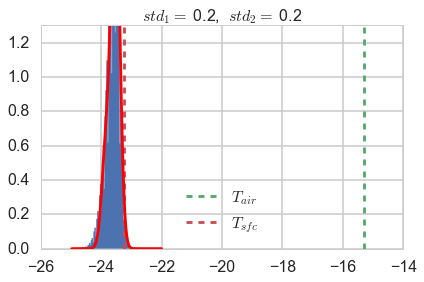

In [61]:
# This section requires inspection by eye in order to select appropriate starting parameter 
# values for the double gaussian fit

from sklearn import mixture
import matplotlib.mlab
from pylab import *
from scipy.optimize import leastsq

def double_gaussian( x, params ):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

def double_gaussian_fit( params ):
    fit = double_gaussian( x, params )
    return (fit - y)

datatype = [('ID', 'int'),
            ('yp', 'int'),
            ('xp', 'int'),
            ('tb', 'float64')]

# To reproduce the figures in the Graphics folder, initial conditions for the fit needs to be determined through 
# an iteration of inspection and fitting
for image in imageList[0]:
    # IR camera data
    IR_image = image + '.txt'
    os.chdir(dirIRData)
    d = np.loadtxt(IR_image, dtype=datatype)
    brighttemp = (d['tb'] - 32.) * 5./9.  # Convert to Celsius

    # Histogram - counts and bins
    fig, ax = plt.subplots(1,1,figsize=(6.5,4))
    cmin = max(-30, np.floor(brighttemp.min()))
    cmax = min(np.ceil(brighttemp.max()), 10.)
    tsp = np.linspace(cmin, cmax, 100)
    n, bins, _ = ax.hist(brighttemp, bins=tsp, normed=True, fill=True, histtype='step')

    # Air and surface temperature
    d = imageListDate[image]
    airTemp = support.T6.sel(time=d).values
    sfcTemp = support.Tsrf.sel(time=d).values
    ax.plot([airTemp, airTemp], [0, 2.], '--', label='$T_{air}$')
    ax.plot([sfcTemp, sfcTemp], [0, 2.], '--', label='$T_{sfc}$')

    # Least squares fit for double gaussian. Starting values found by inspection.
    y = n
    x = bins[:-1] + np.diff(bins)
    params = [1, x[y == max(y)], 1.0, 1, -25, 1.0]
    fit = leastsq( double_gaussian_fit, params )
    ax.plot(x, double_gaussian( x, fit[0] ), c='r')

    # Formatting
    ax.set_title('$std_1=$ ' + str("%.1f" % fit[0][2])
                 + ',  $std_2=$ '+str("%.1f" % fit[0][5]),
                 fontsize=16)
    ax.set_ylim(0,min(1.3, max(y)))
    ax.legend(loc='best', )

    os.chdir(dirPrint)
    fig.savefig(image + '.hist.pdf')
